In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler 
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression 
from ISLP.models import \
(Stepwise , sklearn_selected , sklearn_selection_path)
from l0bnb import fit_path

## Beispiel 9.1 
Wir betrachten den Datensatz $\texttt{Hitters}$ aus dem Paket $\texttt{ISLP}$. Der Code und die Kommentare sind den Ausführungen in Kapitel 6.5 in $\textit{G. James et al., An Introduction to Statistical Learning, Springer Texts in Statistics, Springer Nature Switzerland AG 2023 229}$ entnommen.

### 1 Datenaufbereitung

In [2]:
# Laden des Datensatzes
Hitters = load_data('Hitters')

In [3]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
len(Hitters)

322

In [5]:
# Ziel ist es, die Variable "Salary" mittels der Kovariablen, die die Performance im vorherigen Jahr beschreiben, vorherzusagen.
# Daher löschen wir die Zeilen, für die "Salary" fehlt
Hitters = Hitters.dropna(subset=['Salary'])

In [6]:
Hitters.shape

(263, 20)

### 2 Ein Beispiel für Variablenselektion basierend auf einem Informationskriterium
Zunächst wollen wir das beste Model mittels Vorwärtsselektion auswählen: ausgehend von dem "leeren Modell" werden sukzessive Kovariablen in das Modell aufgenommen, sodass das resultierende Modell eine gewählte Metrik optimiert. Als Metrik wählen wir beispielhaft die Mallow's $C_p$ Statistik (vgl. Kapitel 6 in G.James et al.), welche wir selbst als Funktion definieren, da sie im Paket $\texttt{sklearn}$ nicht implementiert ist.

#### 2.1 Definition des Scorers

In [7]:
# da sklearn versucht, den Score zu maximieren, verwenden wir den negativen C_p score.
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape 
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n # äquivalente Formulierung für C_p, siehe Kapitel 6 in G. James et al.

In [8]:
# wir fitten das volle Modell, um sigma2 zu schätzen
design = MS(Hitters.columns.drop('Salary')).fit(Hitters) 
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [9]:
# Die Funktion sklearn_selected erwartet einen "Scorer" mit den drei Argumenten "estimator", "X", "Y" (s.h. Definition oben).
# wir benutzen die Funktion partial() um das erste Argument mit unserer Schätzung von σ2 zu fixieren.
# wir können dann neg_Cp als Scorer benutzen
neg_Cp = partial(nCp, sigma2)

#### 2.2 Definition der Strategie
Wir wählen die Strategie für unsere Selektion und entscheiden uns beispielhaft für Vorwärtsselektion.

In [10]:
# Objekt Stepwise aus Paket ISLP.models
# Funktion Stepwise.first_peak fügt solange Kovariablen hinzu, bis keine Verbesserung des Scores mehr erfolgt.
strategy = Stepwise.first_peak(design, direction='forward',
max_terms=len(design.terms))

#### 2.3 Fitten des Regressionsmodells mit Vorwärtsselektion
Wir fitten nun ein Regressionsmodell für die Zielvariable $\texttt{salary}$ mittels der oben spezifizierten Vorwärtsselektion, die zugleich die Wahl der Parameter optimal (nach unserem definierten Kriterium) umsetzt.
Dazu nutzen wir die Funktion $\texttt{sklearn selected}$, die als Input ein Model aus $\texttt{statsmodels}$ und eine Suchstrategie benötigt. 

In [11]:
# Wird keine Scoring-Funktion spezifiziert, so wird als Default der "Mean Squared Error" verwendet.
# Dadurch werden alle Variablen verwendet!!
hitters_MSE = sklearn_selected(OLS,strategy)
hitters_MSE.fit(Hitters, Y) 
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [12]:
# Benutzt man C_p als Scorer, so resultiert, wie erwartet, ein Modell mit weniger Variablen:
hitters_Cp = sklearn_selected(OLS,strategy,scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y) 
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### 3 Ein Beispiel für Variablenselektion basierend auf Kreuzvalidierung
Wir möchten eine Vorwärtsselektion von Variablen durchführen und als Kriterium den kreuzvalidierten MSE verwenden.

#### 3.1 Vorwärtsselektion auf Trainingset (ohne Kreuzvalidierung)

In [13]:
# Strategie ist Stepwise fixed_steps, Anzahl steps = Anzahl features
strategy = Stepwise.fixed_steps(design, len(design.terms),direction='forward') 
# sklearn_selection_path speichert alle in Vorwärtsselektion gefundenen Modelle 
# Default Einstellung: in jedem Schritt wird das Modell mit der höchsten Reduction in RSS verwendet.
full_path = sklearn_selection_path(OLS, strategy)

In [14]:
# wir fitten den "full forward selection path" auf Hitters, und berechnen die predicted values
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters) 
Yhat_in.shape
# Yhat_in ist array von predicted values. 263 Beobachtungen, 19 Einflussparameter (erster Eintrag ist mean).

(263, 20)

In [15]:
Hitters['Salary'].mean()

np.float64(535.9258821292775)

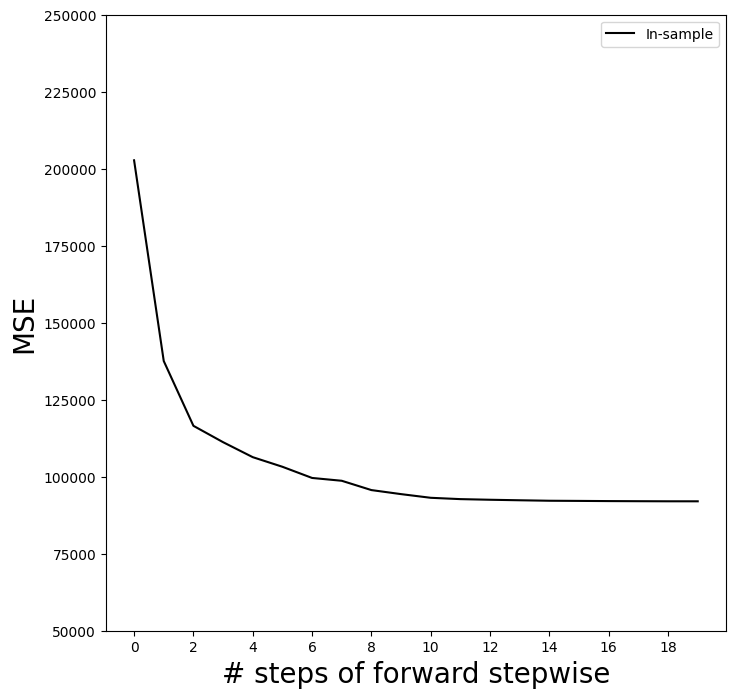

In [16]:
# wie erwartet verbessert sich das in-sample MSE in jedem Schritt (Trainingsset!)
mse_fig, ax = subplots(figsize=(8,8)) 
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0) 
n_steps = insample_mse.shape[0] 
ax.plot(np.arange(n_steps),insample_mse ,'k', label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2]) 
ax.legend()
ax.set_ylim([50000,250000]);

#### 3.2 Vorwärtsselektion mit Kreuzvalidierung
Wir wollen nun Kreuzvalidierung nutzen um den Fehler auf dem Testset entlang des model path zu schätzen.
Hierbei ist zu beachten, dass für alle Aspekte des Model-fittings (inklusive Variablenselektion!) nur die Beobachtungen aus dem Training set verwendet werden dürfen.

In [17]:
K=5
kfold = skm.KFold(K,random_state=0,shuffle=True) # random state fixiert den split
Yhat_cv = skm.cross_val_predict(full_path, Hitters , Y, cv=kfold)
Yhat_cv.shape
# Yhat_cv hat die selbe Form wie Yhat_in. Der Unterschied ist, dass die Vorhersage für jede Zeile (d.h. jede Beobachtung)
# aus Modellen gemacht wurde, die auf training data gefittet wurden, die diese Zeile nicht enthalten.

(263, 20)

In [18]:
# für jedes Modell entlang des full_path berechnen wir den MSE auf den jeweils fünf Testsets
cv_mse = []
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means 
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

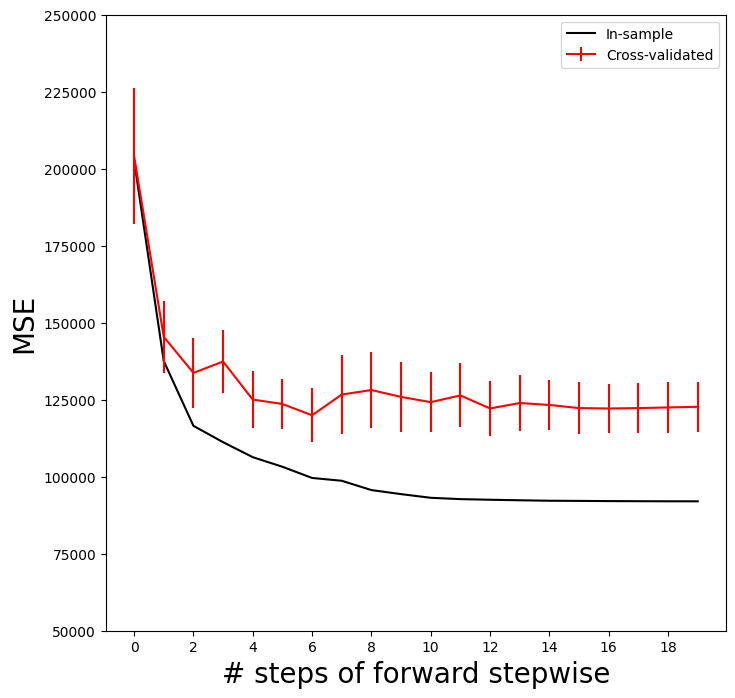

In [19]:
# cv_mse.mean(1) berechnet für jedes Modell den mittleren Fehler aus den 5 Validierungsmengen
ax.errorbar(np.arange(n_steps), cv_mse.mean(1),
cv_mse.std(1) / np.sqrt(K), label='Cross-validated', c='r') # color red
ax.set_ylim([50000,250000]) 
ax.legend()
mse_fig

#### 3.3 Vorwärtsselektion mit Holdout

In [20]:
# Split in 80% Trainingsset und 20% Holdout
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2,
random_state=0)

In [21]:
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx]) # fit auf dem ganzen(!) Trainingset
    Yhat_val = full_path.predict(Hitters.iloc[test_idx]) # Validierung auf Holdout
    errors = (Yhat_val - Y[test_idx,None])**2 
    validation_mse = errors.mean(0)

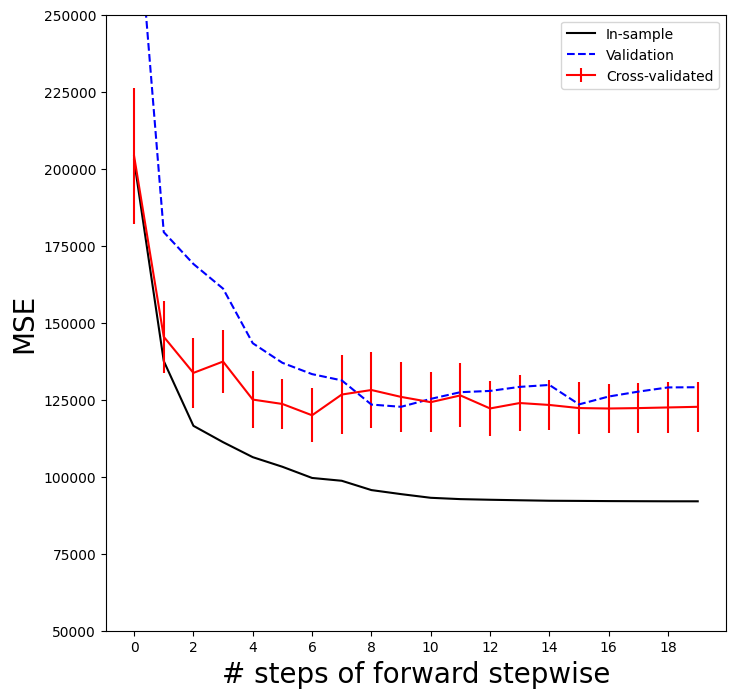

In [22]:
ax.plot(np.arange(n_steps), validation_mse ,'b--', # color blue, broken line
label='Validation')
ax.set_xticks(np.arange(n_steps)[::2]) 
ax.set_ylim([50000,250000]) 
ax.legend()
mse_fig

#### 4 Ridge Regression und Lasso
Für die Implementierung von Variablenselektion mittels Penalisierung sei auf Kapitel 6.5 in $\textit{G. James et al., An Introduction to Statistical Learning, Springer Texts in Statistics, Springer Nature Switzerland AG 2023 229}$ verwiesen. 